In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from scipy import stats
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
from glob import glob as gb
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
def arange(start,end,stride=1):
    return np.arange(start,end+0.00000001,stride)
!pwd

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']
/home/561/erd561/Australian-waters-diagnostics/scripts


In [3]:
input_path = '/g/data/ua8/JRA55-do/v1-3/'

years = list(range(1958, 2018))

output_path = '/g/data/e14/erd561/JRA55-do/v1-3/'

pls_in = sorted(os.listdir(input_path))

file_var = ['u_10', 'v_10', 't_10', 'rain', 'slp']
var = ['uas_10m', 'vas_10m', 'tas_10m', 'prrn', 'psl']

lonW = '90.0'
lonE = '180.0'
latS = '-70.0'
latN = '20.0'

for f,v in zip(file_var, var):
    for y_num in years:
        y = str(y_num)
        
        file_name = \
        [file 
         for file in pls_in 
         if '.' + y + '.' in file 
         and f in file][0]
        
        command = 'ncra -d longitude,' + lonW + ',' + lonE + \
                ' -d latitude,' + latS + ',' + latN + ' -v ' \
                + v + ' ' + input_path + file_name + ' ' + \
                 output_path + file_name
        
        print('$ ' + command) 
        pls_out = os.listdir(output_path)
        if file_name in pls_out:
            print('It is already there! \n')
        else:
            os.system(command)
            print('Done. \n')

$ ncra -d longitude,90.0,180.0 -d latitude,-70.0,20.0 -v uas_10m /g/data/ua8/JRA55-do/v1-3/u_10.1958.18Oct2017.nc /g/data/e14/erd561/JRA55-do/v1-3/u_10.1958.18Oct2017.nc
It is already there! 

$ ncra -d longitude,90.0,180.0 -d latitude,-70.0,20.0 -v uas_10m /g/data/ua8/JRA55-do/v1-3/u_10.1959.18Oct2017.nc /g/data/e14/erd561/JRA55-do/v1-3/u_10.1959.18Oct2017.nc
It is already there! 

$ ncra -d longitude,90.0,180.0 -d latitude,-70.0,20.0 -v uas_10m /g/data/ua8/JRA55-do/v1-3/u_10.1960.18Oct2017.nc /g/data/e14/erd561/JRA55-do/v1-3/u_10.1960.18Oct2017.nc
It is already there! 

$ ncra -d longitude,90.0,180.0 -d latitude,-70.0,20.0 -v uas_10m /g/data/ua8/JRA55-do/v1-3/u_10.1961.18Oct2017.nc /g/data/e14/erd561/JRA55-do/v1-3/u_10.1961.18Oct2017.nc
It is already there! 

$ ncra -d longitude,90.0,180.0 -d latitude,-70.0,20.0 -v uas_10m /g/data/ua8/JRA55-do/v1-3/u_10.1962.18Oct2017.nc /g/data/e14/erd561/JRA55-do/v1-3/u_10.1962.18Oct2017.nc
It is already there! 

$ ncra -d longitude,90.0,180.0 -d l

In [3]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

output_dir = '/home/561/erd561/figures/Australia/'
fig_name = nb_name[:-6]
fig_dir = output_dir + fig_name

output_ls = os.listdir(output_dir)
if fig_name not in output_ls:
    os.mkdir(fig_dir) 

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [5]:
%%time

from dask.distributed import Client
c = Client()
print(c)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.10/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


<Client: scheduler='tcp://127.0.0.1:43536' processes=8 cores=8>
CPU times: user 1.13 s, sys: 237 ms, total: 1.37 s
Wall time: 6.51 s


In [6]:
%%time
latS = -70
latN = 20
lonW = 90-360
lonE = 180-360
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)

output_path = '/g/data/e14/erd561/01deg_jra55v13_iaf/'
pls_out = os.listdir(output_path)

for y in years:
    output_name = 'eta_'+str(y)+'.nc'
    print(output_name+'...')
    
    if output_name in pls_out:
        print('It is already there! \n')
    else:
        eta_t_01_now = cc.get_nc_variable(expt,'ocean_daily.nc','eta_t',
                                          time_units=time_units,n=n_files,offset=offset).\
                                            sel(time=slice(str(y)+'-01-01 00:00:00',str(y+1)+'-01-01 00:00:00')).\
                                            sel(yt_ocean=slice(latS,latN)).\
                                            sel(xt_ocean=slice(lonW,lonE)).\
                                            mean(dim='time')
        eta_t_01_now.load()
        eta_t_01_now.to_netcdf(path=output_path+output_name)
        print('Done. \n')

01deg_jra55v13_iaf
days since 0001-01-01
None
None
eta_1993.nc...
It is already there! 

eta_1994.nc...
It is already there! 

eta_1995.nc...
It is already there! 

eta_1996.nc...
It is already there! 

eta_1997.nc...
It is already there! 

eta_1998.nc...
It is already there! 

eta_1999.nc...
It is already there! 

eta_2000.nc...
It is already there! 

eta_2001.nc...
It is already there! 

eta_2002.nc...
It is already there! 

eta_2003.nc...
It is already there! 

eta_2004.nc...
It is already there! 

eta_2005.nc...
It is already there! 

eta_2006.nc...
It is already there! 

eta_2007.nc...
It is already there! 

eta_2008.nc...
It is already there! 

eta_2009.nc...
It is already there! 

eta_2010.nc...
It is already there! 

eta_2011.nc...
It is already there! 

eta_2012.nc...
It is already there! 

eta_2013.nc...
It is already there! 

eta_2014.nc...
It is already there! 

eta_2015.nc...
It is already there! 

eta_2016.nc...
It is already there! 

eta_2017.nc...
It is already there! 


**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [7]:
%%time
latS = -70
latN = 20
lonW = 90-360
lonE = 180-360
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
temp_01_month = cc.get_nc_variable(expt,'ocean.nc','temp',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            sel(st_ocean=0,method='nearest')

temp_01_month.load()
print(temp_01_month)

01deg_jra55v13_iaf
days since 0001-01-01
None
None
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'temp' (time: 300, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., 273.2834 , 273.28915],
        [      nan,       nan, ..., 273.3283 , 273.32913],
        ...,
        [297.29062, 297.22516, ..., 296.99734, 296.98264],
        [297.23898, 297.2167 , ..., 296.98074, 296.95886]],

       [[      nan,       nan, ..., 272.81653, 272.78738],
        [      nan,       nan, ..., 272.85275, 272.8095 ],
        ...,
        [297.4436 , 297.21423, ..., 296.58884, 296.58023],
        [297.4397 , 297.22632, ..., 296.57843, 296.56793]],

       ...,

       [[      nan,       nan, ..., 271.3473 , 271.3471 ],
        [      nan,       nan, ..., 271.34662, 271.34634],
        ...,
        [301.4287 , 301.43378, ..., 300.3649 , 300.37512],
        [301.376  , 301.3831 , ..., 300.3404 , 300.3514 ]],

       [[      nan,       nan,

In [ ]:
%%time
latS = -70
latN = 20
lonW = 90-360
lonE = 180-360
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
salt_01_month = cc.get_nc_variable(expt,'ocean.nc','salt',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xt_ocean=slice(lonW,lonE)).\
                            sel(st_ocean=0,method='nearest')

salt_01_month.load()
print(salt_01_month)

01deg_jra55v13_iaf
days since 0001-01-01
None
None
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


In [ ]:
%%time
latS = -80
latN = 20
lonW = 90-360
lonE = 180-360
ekey='01deg'
expt = exptdata.exptdict[ekey]['expt']
time_units = exptdata.exptdict[ekey]['time_units']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
print(expt)
print(time_units)
print(n_files)
print(offset)
tx_trans_int_z_01_month = \
cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=slice(latS,latN)).\
                            sel(xu_ocean=slice(lonW,lonE))

tx_trans_int_z_01_month.load()
print(tx_trans_int_z_01_month)

tx_trans_int_z_01 = tx_trans_int_z_01_month.groupby('time.year').mean('time', skipna=True)
print(tx_trans_int_z_01)

tx_trans_int_z_01_cumsum_yt_ocean = tx_trans_int_z_01.cumsum('yt_ocean')
print(tx_trans_int_z_01_cumsum_yt_ocean)

tx_trans_int_z_01_cumsum_yt_ocean_Sv = tx_trans_int_z_01_cumsum_yt_ocean/1e6/1036
print(tx_trans_int_z_01_cumsum_yt_ocean_Sv)

S_Africa_mean_trans_cumsum_yt_ocean = \
cc.get_nc_variable(expt,'ocean_month.nc','tx_trans_int_z',time_units=time_units,n=n_files,offset=offset).\
                            sel(time=slice(exptdata.clim_tstart,exptdata.clim_tend)).\
                            sel(yt_ocean=slice(-80,20)).\
                            sel(xu_ocean=0, method='nearest').\
                            mean(dim='time').\
                            cumsum(dim='yt_ocean')

S_Africa_mean_trans_cumsum_yt_ocean.load()
print(S_Africa_mean_trans_cumsum_yt_ocean)

S_Africa_mean_trans_Sv = S_Africa_mean_trans_cumsum_yt_ocean.sel(yt_ocean=20,method='nearest')/1e6/1036
print(S_Africa_mean_trans_Sv)

gyre_psi = -tx_trans_int_z_01_cumsum_yt_ocean_Sv + S_Africa_mean_trans_Sv
gyre_psi = gyre_psi.where((np.isfinite(tx_trans_int_z_01.sel(year=1993))), np.nan)
print(gyre_psi)

In [49]:
%%time
output_path_list = sorted(gb(output_path+'*'))
eta_t = xr.open_mfdataset(output_path_list, concat_dim='year').eta_t
eta_t = eta_t.assign_coords(year=years)
eta_t.load()
print(eta_t)

<xarray.DataArray 'eta_t' (year: 25, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., -1.553424, -1.553023],
        [      nan,       nan, ..., -1.554771, -1.5544  ],
        ...,
        [ 0.436164,  0.436063, ...,  0.623157,  0.622838],
        [ 0.438985,  0.438865, ...,  0.624114,  0.623857]],

       [[      nan,       nan, ..., -1.538167, -1.537931],
        [      nan,       nan, ..., -1.539503, -1.539326],
        ...,
        [ 0.397539,  0.398372, ...,  0.62935 ,  0.628091],
        [ 0.404109,  0.404905, ...,  0.626661,  0.625244]],

       ...,

       [[      nan,       nan, ..., -1.573167, -1.572852],
        [      nan,       nan, ..., -1.574003, -1.573632],
        ...,
        [ 0.512353,  0.512327, ...,  0.621191,  0.621616],
        [ 0.513968,  0.514305, ...,  0.61878 ,  0.618931]],

       [[      nan,       nan, ..., -1.59154 , -1.591264],
        [      nan,       nan, ..., -1.593481, -1.593206],
        ...,
        [ 0.46673 ,  0.467606, ...

In [11]:
%%time

latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 'rain'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

rain_all = xr.open_mfdataset(all_files).prrn

rain_all.load()
print(rain_all)

<xarray.DataArray 'prrn' (time: 25, latitude: 161, longitude: 161)>
array([[[9.617032e-09, 8.337044e-09, ..., 1.905908e-06, 1.843413e-06],
        [9.569601e-09, 7.656000e-09, ..., 2.116243e-06, 1.985681e-06],
        ...,
        [7.249512e-05, 7.461548e-05, ..., 1.075262e-05, 1.067118e-05],
        [7.586410e-05, 7.727787e-05, ..., 1.136168e-05, 1.085580e-05]],

       [[1.139814e-08, 8.845775e-09, ..., 4.848063e-07, 6.055243e-07],
        [1.079644e-08, 8.683325e-09, ..., 1.202812e-06, 1.316516e-06],
        ...,
        [6.003840e-05, 6.015834e-05, ..., 2.053162e-05, 2.001345e-05],
        [6.306250e-05, 6.379285e-05, ..., 2.076575e-05, 2.086276e-05]],

       ...,

       [[7.459549e-09, 5.428058e-09, ..., 6.826586e-07, 7.962033e-07],
        [6.709236e-09, 5.251623e-09, ..., 1.448103e-06, 1.476224e-06],
        ...,
        [7.652512e-05, 7.795475e-05, ..., 2.000465e-05, 1.932769e-05],
        [7.272094e-05, 7.383179e-05, ..., 1.816724e-05, 1.842306e-05]],

       [[7.420942e-09,

In [12]:
%%time

latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 't_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

t_10_all = xr.open_mfdataset(all_files).tas_10m  

t_10_all.load()
print(t_10_all)

<xarray.DataArray 'tas_10m' (time: 25, latitude: 161, longitude: 161)>
array([[[257.59256, 257.59256, ..., 261.04608, 261.0913 ],
        [258.21426, 258.21426, ..., 261.91476, 261.95865],
        ...,
        [300.1658 , 300.0461 , ..., 298.61917, 298.60165],
        [300.0957 , 299.94522, ..., 298.50906, 298.4882 ]],

       [[257.59256, 257.59256, ..., 260.8303 , 260.9211 ],
        [258.21426, 258.21426, ..., 261.6275 , 261.7099 ],
        ...,
        [300.1004 , 299.9799 , ..., 298.9499 , 298.93292],
        [300.02817, 299.87994, ..., 298.78818, 298.7662 ]],

       ...,

       [[257.59256, 257.59256, ..., 261.55838, 261.60956],
        [258.21426, 258.21426, ..., 262.459  , 262.50974],
        ...,
        [300.8656 , 300.7565 , ..., 299.3125 , 299.2859 ],
        [300.7536 , 300.61136, ..., 299.20712, 299.17462]],

       [[257.59256, 257.59274, ..., 261.58215, 261.62183],
        [258.21426, 258.21426, ..., 262.3877 , 262.42746],
        ...,
        [300.7819 , 300.69586, .

In [13]:
%%time

latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 'u_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

u_10_all = xr.open_mfdataset(all_files).uas_10m   

u_10_all.load()
print(u_10_all)

<xarray.DataArray 'uas_10m' (time: 25, latitude: 161, longitude: 161)>
array([[[-8.959103e+00, -9.185435e+00, ...,  3.678540e-01,  4.142455e-01],
        [-9.538368e+00, -9.677067e+00, ...,  4.786964e-01,  5.926184e-01],
        ...,
        [ 1.544562e+00,  1.404381e+00, ..., -6.589673e+00, -6.613897e+00],
        [ 1.447655e+00,  1.335200e+00, ..., -6.337334e+00, -6.354620e+00]],

       [[-9.071602e+00, -9.295076e+00, ...,  8.775599e-03,  7.148299e-02],
        [-9.747133e+00, -9.883302e+00, ...,  4.506692e-02,  1.761953e-01],
        ...,
        [ 1.602340e+00,  1.513393e+00, ..., -5.539237e+00, -5.557720e+00],
        [ 1.451117e+00,  1.400476e+00, ..., -5.394783e+00, -5.400683e+00]],

       ...,

       [[-9.606175e+00, -9.829502e+00, ..., -2.832742e-01, -2.066557e-01],
        [-1.021535e+01, -1.036444e+01, ..., -1.285230e-01, -2.850509e-03],
        ...,
        [ 1.460648e+00,  1.336522e+00, ..., -6.674020e+00, -6.686288e+00],
        [ 1.267538e+00,  1.188947e+00, ..., -6.4

In [14]:
%%time

latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 'slp'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

slp_all = xr.open_mfdataset(all_files).psl   

slp_all.load()
print(slp_all)

<xarray.DataArray 'psl' (time: 25, latitude: 161, longitude: 161)>
array([[[100370.85 , 100418.88 , ...,  98174.53 ,  98160.84 ],
        [ 99975.1  , 100025.98 , ...,  98155.1  ,  98143.68 ],
        ...,
        [100929.24 , 100936.516, ..., 101529.75 , 101530.77 ],
        [100916.19 , 100928.375, ..., 101560.234, 101561.16 ]],

       [[100794.22 , 100846.02 , ...,  98565.18 ,  98549.02 ],
        [100395.57 , 100451.195, ...,  98538.62 ,  98525.49 ],
        ...,
        [100875.32 , 100881.625, ..., 101386.04 , 101388.02 ],
        [100863.1  , 100874.42 , ..., 101413.34 , 101415.22 ]],

       ...,

       [[100576.68 , 100628.62 , ...,  98472.32 ,  98462.13 ],
        [100171.3  , 100225.41 , ...,  98447.71 ,  98439.99 ],
        ...,
        [100865.99 , 100872.75 , ..., 101555.99 , 101557.305],
        [100855.79 , 100867.16 , ..., 101589.05 , 101590.37 ]],

       [[100696.5  , 100750.35 , ...,  98341.695,  98329.35 ],
        [100295.79 , 100352.05 , ...,  98323.99 ,  98313

In [15]:
%%time

latS = -70
latN = 20
lonW = 90-360
lonE = 180-360

var = 'v_10'

all_files = sorted(gb('/g/data/e14/erd561/JRA55-do/v1-3/' + var + '.*.*.nc'))

v_10_all = xr.open_mfdataset(all_files).vas_10m

v_10_all.load()
print(v_10_all)

<xarray.DataArray 'vas_10m' (time: 25, latitude: 161, longitude: 161)>
array([[[ 3.651821,  3.731537, ...,  2.870504,  2.662094],
        [ 4.940031,  4.981736, ...,  2.286523,  2.109486],
        ...,
        [ 1.568398,  1.361881, ..., -1.972805, -2.036986],
        [ 1.728541,  1.521613, ..., -1.89851 , -1.947677]],

       [[ 3.773924,  3.868824, ...,  3.466481,  3.235808],
        [ 5.172908,  5.231553, ...,  2.751938,  2.538381],
        ...,
        [ 1.203737,  0.97777 , ..., -1.60026 , -1.62277 ],
        [ 1.358551,  1.114633, ..., -1.575462, -1.59291 ]],

       ...,

       [[ 3.872682,  3.990711, ...,  2.516684,  2.330794],
        [ 5.171262,  5.256763, ...,  1.874432,  1.706751],
        ...,
        [ 1.491145,  1.366104, ..., -2.210477, -2.231614],
        [ 1.557764,  1.433358, ..., -2.154506, -2.16432 ]],

       [[ 3.246724,  3.365044, ...,  2.682318,  2.491387],
        [ 4.464511,  4.554462, ...,  2.103313,  1.935813],
        ...,
        [ 1.250876,  1.145742, .

In [50]:
temp_01 = temp_01_month.groupby('time.year').mean('time', skipna=True)
print(temp_01)
temp_01_mean = temp_01.mean(dim='year')
print(temp_01_mean)
temp_01_anom = temp_01 - temp_01_mean

salt_01 = salt_01_month.groupby('time.year').mean('time', skipna=True)
print(salt_01)
salt_01_mean = salt_01.mean(dim='year')
print(salt_01_mean)
salt_01_anom = salt_01 - salt_01_mean

gyre_psi_mean = gyre_psi.mean(dim='year')
print(gyre_psi_mean)
gyre_psi_anom = gyre_psi - gyre_psi_mean

eta_t_mean = eta_t.mean(dim='year')
print(eta_t_mean)
eta_t_anom = eta_t - eta_t_mean

rain = rain_all.groupby('time.year').mean('time', skipna=True)
print(rain)
rain_mean = rain.mean(dim='year')
print(rain_mean)
rain_anom = rain - rain_mean

t_10 = t_10_all.groupby('time.year').mean('time', skipna=True)
print(t_10)
t_10_mean = t_10.mean(dim='year')
print(t_10_mean)
t_10_anom = t_10 - t_10_mean

u_10 = u_10_all.groupby('time.year').mean('time', skipna=True)
print(u_10)
u_10_mean = u_10.mean(dim='year')
print(u_10_mean)
u_10_anom = u_10 - u_10_mean

v_10 = v_10_all.groupby('time.year').mean('time', skipna=True)
print(v_10)
v_10_mean = v_10.mean(dim='year')
print(v_10_mean)
v_10_anom = v_10 - v_10_mean

slp = slp_all.groupby('time.year').mean('time', skipna=True)
print(slp)
slp_mean = slp.mean(dim='year')
print(slp_mean)
slp_anom = slp - slp_mean

<xarray.DataArray 'temp' (year: 25, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., 271.7264 , 271.72592],
        [      nan,       nan, ..., 271.73196, 271.729  ],
        ...,
        [300.60236, 300.52548, ..., 298.90384, 298.90314],
        [300.45926, 300.41058, ..., 298.88864, 298.88593]],

       [[      nan,       nan, ..., 271.43204, 271.43036],
        [      nan,       nan, ..., 271.4318 , 271.4304 ],
        ...,
        [300.4228 , 300.37872, ..., 299.55075, 299.54694],
        [300.26535, 300.2357 , ..., 299.51984, 299.51306]],

       ...,

       [[      nan,       nan, ..., 271.5356 , 271.53067],
        [      nan,       nan, ..., 271.53622, 271.5279 ],
        ...,
        [301.27817, 301.25903, ..., 299.60626, 299.61057],
        [301.22958, 301.19168, ..., 299.58273, 299.58508]],

       [[      nan,       nan, ..., 271.75876, 271.75757],
        [      nan,       nan, ..., 271.75613, 271.75504],
        ...,
        [301.19467, 301.19592, ...,

In [21]:
speed_anom = (u_10_anom**2 + v_10_anom**2)**(1/2)
print(speed_anom)

u_10_anom_norm = u_10_anom / (u_10_anom**2 + v_10_anom**2)**(1/4)
v_10_anom_norm = v_10_anom / (u_10_anom**2 + v_10_anom**2)**(1/4)

print(u_10_anom_norm)

<xarray.DataArray (year: 25, latitude: 161, longitude: 161)>
array([[[0.636522, 0.626618, ..., 0.398709, 0.432491],
        [0.673031, 0.67005 , ..., 0.456188, 0.472483],
        ...,
        [0.399457, 0.346488, ..., 0.858417, 0.883734],
        [0.47223 , 0.426243, ..., 0.812032, 0.840876]],

       [[0.543962, 0.535009, ..., 0.486682, 0.457939],
        [0.538576, 0.533198, ..., 0.433411, 0.420638],
        ...,
        [0.135025, 0.133823, ..., 0.426217, 0.426898],
        [0.15494 , 0.123516, ..., 0.359889, 0.362445]],

       ...,

       [[0.246783, 0.260203, ..., 1.044496, 1.036362],
        [0.273649, 0.288989, ..., 1.059358, 1.059674],
        ...,
        [0.315368, 0.353533, ..., 1.082636, 1.071082],
        [0.289436, 0.345766, ..., 1.063816, 1.051496]],

       [[0.38924 , 0.378917, ..., 0.68997 , 0.694553],
        [0.453884, 0.438407, ..., 0.679275, 0.68084 ],
        ...,
        [0.243379, 0.316132, ..., 0.345996, 0.32671 ],
        [0.208204, 0.273094, ..., 0.353138,

In [22]:
%%time

lon_coarse = arange(lonW,lonE,0.25)
lat_coarse = arange(latS,latN,0.25)

lon_coarse_grid, lat_coarse_grid = np.meshgrid(lon_coarse,lat_coarse)

yt_ocean = temp_01.yt_ocean
xt_ocean = temp_01.xt_ocean

xt_ocean_grid, yt_ocean_grid = np.meshgrid(xt_ocean, yt_ocean)
xt_ocean_flat = np.transpose(xt_ocean_grid.flatten('F'))
yt_ocean_flat = yt_ocean_grid.flatten('F')
flat_list = [xt_ocean_flat, yt_ocean_flat]    
flat_list_points = np.transpose(flat_list)


for yi, y in enumerate(years):
    temp_01_flatten = temp_01.sel(year=y).stack(z=('xt_ocean', 'yt_ocean')).values
    
    if y == 1993:
        temp_01_coarse = scipy.interpolate.griddata(flat_list_points, temp_01_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')
        
    else:
        temp_01_coarse = np.dstack((temp_01_coarse, 
                                    scipy.interpolate.griddata(flat_list_points, temp_01_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')))
        
    print(str(temp_01_coarse.shape) + ' ' + str(y) + ' OK')

(361, 361) 1993 OK
(361, 361, 2) 1994 OK
(361, 361, 3) 1995 OK
(361, 361, 4) 1996 OK
(361, 361, 5) 1997 OK
(361, 361, 6) 1998 OK


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 7) 1999 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 8) 2000 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 9) 2001 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 10) 2002 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 11) 2003 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 12) 2004 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 13) 2005 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 14) 2006 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 15) 2007 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 16) 2008 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 17) 2009 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 18) 2010 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 19) 2011 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 20) 2012 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 21) 2013 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 22) 2014 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 23) 2015 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 24) 2016 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 25) 2017 OK
CPU times: user 1min 55s, sys: 1.68 s, total: 1min 57s
Wall time: 1min 47s


In [23]:
%%time

for yi, y in enumerate(years):
    salt_01_flatten = salt_01.sel(year=y).stack(z=('xt_ocean', 'yt_ocean')).values
    
    if y == 1993:
        salt_01_coarse = scipy.interpolate.griddata(flat_list_points, salt_01_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')
        
    else:
        salt_01_coarse = np.dstack((salt_01_coarse, 
                                    scipy.interpolate.griddata(flat_list_points, salt_01_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')))
        
    print(str(salt_01_coarse.shape) + ' ' + str(y) + ' OK')

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361) 1993 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 2) 1994 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 3) 1995 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 4) 1996 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


(361, 361, 5) 1997 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 6) 1998 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 7) 1999 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 8) 2000 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 9) 2001 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 10) 2002 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 11) 2003 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


(361, 361, 12) 2004 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


(361, 361, 13) 2005 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


(361, 361, 14) 2006 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


(361, 361, 15) 2007 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 16) 2008 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 17) 2009 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 18) 2010 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


(361, 361, 19) 2011 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 20) 2012 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 21) 2013 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 22) 2014 OK


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 23) 2015 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 24) 2016 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 25) 2017 OK
CPU times: user 1min 57s, sys: 2.49 s, total: 1min 59s
Wall time: 1min 49s


In [30]:
%%time

yt_ocean = gyre_psi.yt_ocean
xu_ocean = gyre_psi.xu_ocean

xu_ocean_grid, yt_ocean_grid = np.meshgrid(xu_ocean, yt_ocean)
xu_ocean_flat = np.transpose(xu_ocean_grid.flatten('F'))
yt_ocean_flat = yt_ocean_grid.flatten('F')
flat_list = [xu_ocean_flat, yt_ocean_flat]    
flat_list_points = np.transpose(flat_list)

for yi, y in enumerate(years):
    gyre_psi_flatten = gyre_psi.sel(year=y).stack(z=('xu_ocean', 'yt_ocean')).values
    
    if y == 1993:
        gyre_psi_coarse = scipy.interpolate.griddata(flat_list_points, gyre_psi_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')
        
    else:
        gyre_psi_coarse = np.dstack((gyre_psi_coarse, 
                                    scipy.interpolate.griddata(flat_list_points, gyre_psi_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')))
        
    print(str(gyre_psi_coarse.shape) + ' ' + str(y) + ' OK')

distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 56% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 57% CPU time recently (threshold: 10%)


(361, 361) 1993 OK


distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)


(361, 361, 2) 1994 OK


distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


(361, 361, 3) 1995 OK


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 4) 1996 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 5) 1997 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 6) 1998 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


(361, 361, 7) 1999 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 8) 2000 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 9) 2001 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 10) 2002 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 11) 2003 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 12) 2004 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


(361, 361, 13) 2005 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 14) 2006 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


(361, 361, 15) 2007 OK


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


(361, 361, 16) 2008 OK


distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


(361, 361, 17) 2009 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


(361, 361, 18) 2010 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 19) 2011 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


(361, 361, 20) 2012 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


(361, 361, 21) 2013 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 22) 2014 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


(361, 361, 23) 2015 OK


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 24) 2016 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 25) 2017 OK
CPU times: user 2min 34s, sys: 2.06 s, total: 2min 36s
Wall time: 2min 21s


In [52]:
%%time

yt_ocean = eta_t.yt_ocean
xt_ocean = eta_t.xt_ocean

xt_ocean_grid, yt_ocean_grid = np.meshgrid(xt_ocean, yt_ocean)
xt_ocean_flat = np.transpose(xt_ocean_grid.flatten('F'))
yt_ocean_flat = yt_ocean_grid.flatten('F')
flat_list = [xt_ocean_flat, yt_ocean_flat]    
flat_list_points = np.transpose(flat_list)

for yi, y in enumerate(years):
    eta_t_flatten = eta_t.sel(year=y).stack(z=('xt_ocean', 'yt_ocean')).values
    
    if y == 1993:
        eta_t_coarse = scipy.interpolate.griddata(flat_list_points, eta_t_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')
        
    else:
        eta_t_coarse = np.dstack((eta_t_coarse, 
                                    scipy.interpolate.griddata(flat_list_points, eta_t_flatten, 
                                           (lon_coarse_grid, lat_coarse_grid), 
                                           method='nearest')))
        
    print(str(eta_t_coarse.shape) + ' ' + str(y) + ' OK')

<xarray.DataArray 'eta_t' (year: 25, yt_ocean: 1186, xt_ocean: 900)>
array([[[      nan,       nan, ..., -1.553424, -1.553023],
        [      nan,       nan, ..., -1.554771, -1.5544  ],
        ...,
        [ 0.436164,  0.436063, ...,  0.623157,  0.622838],
        [ 0.438985,  0.438865, ...,  0.624114,  0.623857]],

       [[      nan,       nan, ..., -1.538167, -1.537931],
        [      nan,       nan, ..., -1.539503, -1.539326],
        ...,
        [ 0.397539,  0.398372, ...,  0.62935 ,  0.628091],
        [ 0.404109,  0.404905, ...,  0.626661,  0.625244]],

       ...,

       [[      nan,       nan, ..., -1.573167, -1.572852],
        [      nan,       nan, ..., -1.574003, -1.573632],
        ...,
        [ 0.512353,  0.512327, ...,  0.621191,  0.621616],
        [ 0.513968,  0.514305, ...,  0.61878 ,  0.618931]],

       [[      nan,       nan, ..., -1.59154 , -1.591264],
        [      nan,       nan, ..., -1.593481, -1.593206],
        ...,
        [ 0.46673 ,  0.467606, ...

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


(361, 361) 1993 OK


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


(361, 361, 2) 1994 OK


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 3) 1995 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


(361, 361, 4) 1996 OK


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


(361, 361, 5) 1997 OK


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 6) 1998 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


(361, 361, 7) 1999 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


(361, 361, 8) 2000 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


(361, 361, 9) 2001 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


(361, 361, 10) 2002 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


(361, 361, 11) 2003 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 12) 2004 OK


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


(361, 361, 13) 2005 OK


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


(361, 361, 14) 2006 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


(361, 361, 15) 2007 OK


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 16) 2008 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 17) 2009 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 18) 2010 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


(361, 361, 19) 2011 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 20) 2012 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 21) 2013 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 22) 2014 OK


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 23) 2015 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


(361, 361, 24) 2016 OK


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


(361, 361, 25) 2017 OK
CPU times: user 1min 58s, sys: 1.36 s, total: 1min 59s
Wall time: 1min 50s


In [54]:
%%time

# temp_01_trans = np.transpose(temp_01_coarse, (2,1,0))
# temp_01_slopes = xr.DataArray(np.zeros([lat_coarse.shape[0], lon_coarse.shape[0]]), dims=(
#     'yt_ocean', 'xt_ocean'), coords=[lat_coarse, lon_coarse], name='temp')
# for iid, i in enumerate(lat_coarse):
#     for jid, j in enumerate(lon_coarse):
#         temp_01_slopes[jid, iid], _, _, _, _ = \
#         stats.linregress(years, temp_01_trans[:, iid, jid])
#     print('lat_coarse ' + str(np.array(i)))
# print(temp_01_slopes)    

# salt_01_trans = np.transpose(salt_01_coarse, (2,1,0))
# salt_01_slopes = xr.DataArray(np.zeros([lat_coarse.shape[0], lon_coarse.shape[0]]), dims=(
#     'yt_ocean', 'xt_ocean'), coords=[lat_coarse, lon_coarse], name='salt')
# for iid, i in enumerate(lat_coarse):
#     for jid, j in enumerate(lon_coarse):
#         salt_01_slopes[jid, iid], _, _, _, _ = \
#         stats.linregress(years, salt_01_trans[:, iid, jid])
#     print('lat_coarse ' + str(np.array(i)))
# print(salt_01_slopes)

gyre_psi_trans = np.transpose(gyre_psi_coarse, (2,1,0))
gyre_psi_slopes = xr.DataArray(np.zeros([lat_coarse.shape[0], lon_coarse.shape[0]]), dims=(
    'yt_ocean', 'xu_ocean'), coords=[lat_coarse, lon_coarse], name='gyre_psi')
for iid, i in enumerate(lat_coarse):
    for jid, j in enumerate(lon_coarse):
        gyre_psi_slopes[jid, iid], _, _, _, _ = \
        stats.linregress(years, gyre_psi_trans[:, iid, jid])
    print('lat_coarse ' + str(np.array(i)))
print(gyre_psi_slopes)

eta_t_trans = np.transpose(eta_t_coarse, (2,1,0))
eta_t_slopes = xr.DataArray(np.zeros([lat_coarse.shape[0], lon_coarse.shape[0]]), dims=(
    'yt_ocean', 'xt_ocean'), coords=[lat_coarse, lon_coarse], name='eta_t')
for iid, i in enumerate(lat_coarse):
    for jid, j in enumerate(lon_coarse):
        eta_t_slopes[jid, iid], _, _, _, _ = \
        stats.linregress(years, eta_t_trans[:, iid, jid])
    print('lat_coarse ' + str(np.array(i)))
print(eta_t_slopes)



lat_coarse -70.0
lat_coarse -69.75
lat_coarse -69.5
lat_coarse -69.25
lat_coarse -69.0
lat_coarse -68.75
lat_coarse -68.5
lat_coarse -68.25
lat_coarse -68.0
lat_coarse -67.75
lat_coarse -67.5
lat_coarse -67.25
lat_coarse -67.0
lat_coarse -66.75
lat_coarse -66.5
lat_coarse -66.25
lat_coarse -66.0
lat_coarse -65.75
lat_coarse -65.5
lat_coarse -65.25
lat_coarse -65.0
lat_coarse -64.75
lat_coarse -64.5
lat_coarse -64.25
lat_coarse -64.0
lat_coarse -63.75
lat_coarse -63.5
lat_coarse -63.25
lat_coarse -63.0
lat_coarse -62.75
lat_coarse -62.5
lat_coarse -62.25
lat_coarse -62.0
lat_coarse -61.75
lat_coarse -61.5
lat_coarse -61.25
lat_coarse -61.0
lat_coarse -60.75
lat_coarse -60.5
lat_coarse -60.25
lat_coarse -60.0
lat_coarse -59.75
lat_coarse -59.5
lat_coarse -59.25
lat_coarse -59.0
lat_coarse -58.75
lat_coarse -58.5
lat_coarse -58.25
lat_coarse -58.0
lat_coarse -57.75
lat_coarse -57.5
lat_coarse -57.25
lat_coarse -57.0
lat_coarse -56.75
lat_coarse -56.5
lat_coarse -56.25
lat_coarse -56.0
lat

lat_coarse -51.25
lat_coarse -51.0
lat_coarse -50.75
lat_coarse -50.5
lat_coarse -50.25
lat_coarse -50.0
lat_coarse -49.75
lat_coarse -49.5
lat_coarse -49.25
lat_coarse -49.0
lat_coarse -48.75
lat_coarse -48.5
lat_coarse -48.25
lat_coarse -48.0
lat_coarse -47.75
lat_coarse -47.5
lat_coarse -47.25
lat_coarse -47.0
lat_coarse -46.75
lat_coarse -46.5
lat_coarse -46.25
lat_coarse -46.0
lat_coarse -45.75
lat_coarse -45.5
lat_coarse -45.25
lat_coarse -45.0
lat_coarse -44.75
lat_coarse -44.5
lat_coarse -44.25
lat_coarse -44.0
lat_coarse -43.75
lat_coarse -43.5
lat_coarse -43.25
lat_coarse -43.0
lat_coarse -42.75
lat_coarse -42.5
lat_coarse -42.25
lat_coarse -42.0
lat_coarse -41.75
lat_coarse -41.5
lat_coarse -41.25
lat_coarse -41.0
lat_coarse -40.75
lat_coarse -40.5
lat_coarse -40.25
lat_coarse -40.0
lat_coarse -39.75
lat_coarse -39.5
lat_coarse -39.25
lat_coarse -39.0
lat_coarse -38.75
lat_coarse -38.5
lat_coarse -38.25
lat_coarse -38.0
lat_coarse -37.75
lat_coarse -37.5
lat_coarse -37.25
la

1993 OK
1994 OK
1995 OK
1996 OK
1997 OK
1998 OK
1999 OK
2000 OK
2001 OK
2002 OK
2003 OK
2004 OK
2005 OK
2006 OK
2007 OK
2008 OK
2009 OK
2010 OK
2011 OK
2012 OK
2013 OK
2014 OK
2015 OK
2016 OK
2017 OK


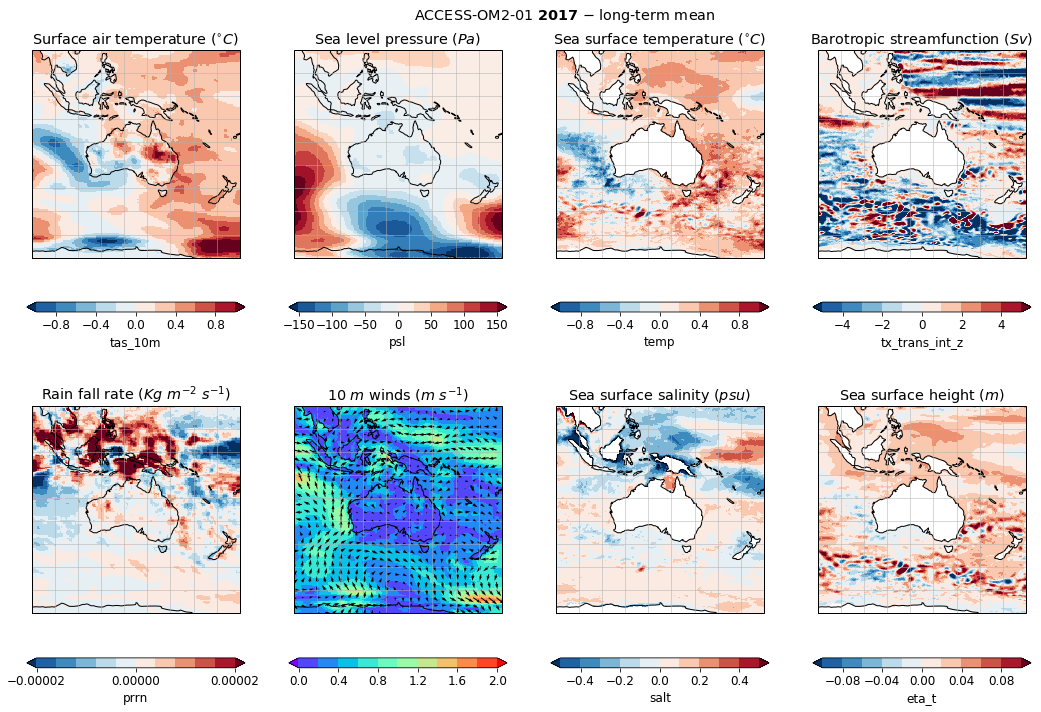

In [74]:
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(fig_dir, fig_name[0:4]+fname+'.png'),dpi=150, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return   


# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='',
                                    linewidth=1)
fig = plt.figure() 
fig.set_size_inches(18,12)
matplotlib.rcParams.update({'font.size': 12}) 
col = 4
row = 2

for y_num in years:
    y = str(y_num)

    fig.suptitle(r'ACCESS-OM2-01 $\bf{' + y + '}$ $-$ long-term mean', 
                 x=0.54, y=0.93)

    ax = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-1,1,0.2)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = t_10_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Surface air temperature ($^{\circ}C$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.00002,0.00002,0.000004)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = rain_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal', 
                                             'ticks':[-0.00002, 0, 0.00002]})
    plt.title('Rain fall rate ($Kg\ m^{-2}\ s^{-1}$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-150,150,25)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = slp_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Sea level pressure ($Pa$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('rainbow')
    levels = arange(0,2,0.2)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = speed_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    n = 6
    plt.quiver(u_10_anom_norm.longitude[0:161:n], 
               u_10_anom_norm.latitude[0:161:n], 
               u_10_anom_norm.sel(year=y_num)[0:161:n,0:161:n], 
               v_10_anom_norm.sel(year=y_num)[0:161:n,0:161:n],
               width=0.005, scale=25)
    plt.title('10 $m$ winds ($m\ s^{-1}$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-1,1,0.2)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = temp_01_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Sea surface temperature ($^{\circ}C$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.5,0.5,0.1)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = salt_01_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Sea surface salinity ($psu$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')
    
    ax = plt.subplot2grid((row, col), (0, 3), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-5,5,1)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = gyre_psi_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Barotropic streamfunction ($Sv$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')
    
    ax = plt.subplot2grid((row, col), (1, 3), rowspan=1, colspan=1, 
                          projection=ccrs.PlateCarree(central_longitude=0))
    cmap = plt.get_cmap('RdBu_r')
    levels = arange(-0.1,0.1,0.02)
    ax.add_feature(land_50m)
    ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
    p = eta_t_anom.sel(
        year=y_num).plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                                cbar_kwargs={'orientation':'horizontal'})
    plt.title('Sea surface height ($m$)')
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

    savefigure(y)
    
    print(y + ' OK')

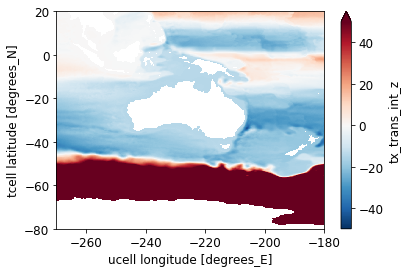

In [59]:
gyre_psi_mean.plot(vmax=50)

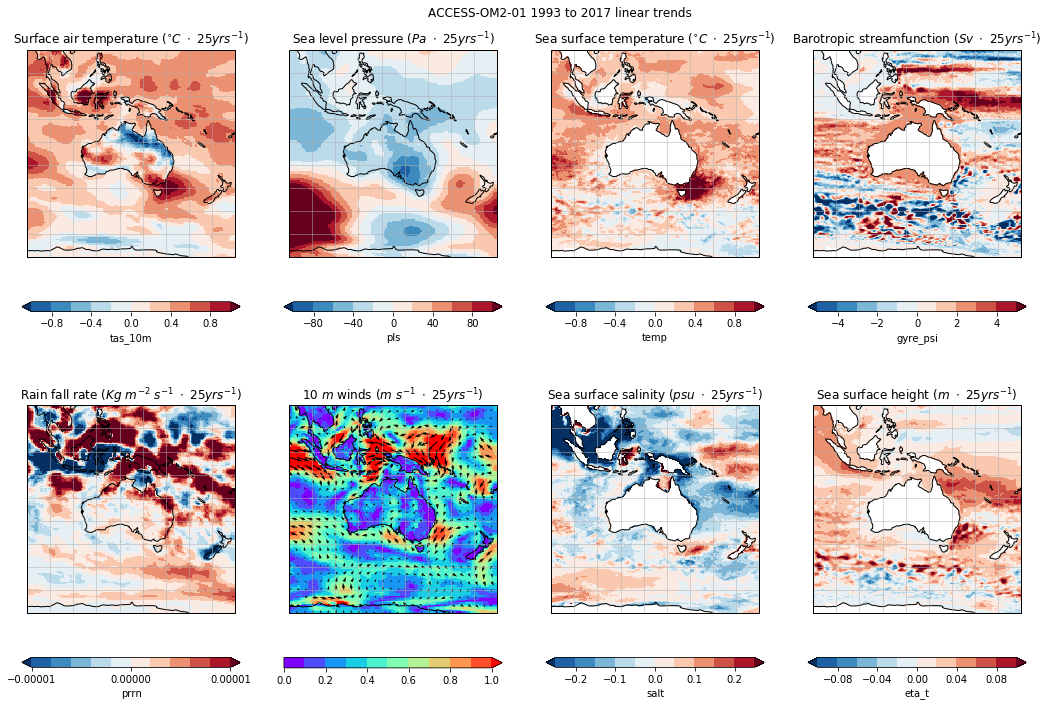

In [75]:
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(fig_dir, fig_name[0:4]+fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return   


# General plotting stuff
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m= cft.NaturalEarthFeature('physical', 'land', '110m',
                                    edgecolor='black',
                                    facecolor='',
                                    linewidth=1)
fig = plt.figure() 
fig.set_size_inches(18,12)
matplotlib.rcParams.update({'font.size': 10}) 
col = 4
row = 2

fig.suptitle(r'ACCESS-OM2-01 1993 to 2017 linear trends', 
             x=0.54, y=0.93)

ax    = plt.subplot2grid((row, col), (0, 0), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-1,1,0.2)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
t_10_plot = t_10_slopes * 25
p = t_10_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Surface air temperature ($^{\circ}C\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (1, 0), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.00001,0.00001,0.000002)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
rain_plot = rain_slopes * 25
p = rain_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal', 
                                         'ticks':[-0.00001, 0, 0.00001]})
plt.title('Rain fall rate ($Kg\ m^{-2}\ s^{-1}\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (0, 1), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-100,100,20)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
slp_plot = slp_slopes * 25
p = slp_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Sea level pressure ($Pa\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (1, 1), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('rainbow')
levels = arange(0,1,0.1)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
speed_slopes = (u_10_slopes**2 + v_10_slopes**2)**(1/2)
speed_plot = speed_slopes * 25
p = speed_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='max', 
                            cbar_kwargs={'orientation':'horizontal'})
u_10_slopes_norm = u_10_slopes / (u_10_slopes**2 + v_10_slopes**2)**(1/4)
v_10_slopes_norm = v_10_slopes / (u_10_slopes**2 + v_10_slopes**2)**(1/4)
u_10_plot = u_10_slopes * 25
v_10_plot = v_10_slopes * 25
n = 6
plt.quiver(u_10_anom_norm.longitude[0:161:n], 
           u_10_anom_norm.latitude[0:161:n], 
           u_10_plot[0:161:n,0:161:n], 
           v_10_plot[0:161:n,0:161:n],
           width=0.005, scale=25*0.9)
plt.title('10 $m$ winds ($m\ s^{-1}\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (0, 2), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-1,1,0.2)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
temp_01_plot = temp_01_slopes * 25
p = temp_01_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Sea surface temperature ($^{\circ}C\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (1, 2), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.25,0.25,0.05)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
salt_01_plot = salt_01_slopes * 25
p = salt_01_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Sea surface salinity ($psu\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (0, 3), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-5,5,1)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
gyre_psi_plot = gyre_psi_slopes * 25
p = gyre_psi_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Barotropic streamfunction ($Sv\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

ax = plt.subplot2grid((row, col), (1, 3), rowspan=1, colspan=1, 
                      projection=ccrs.PlateCarree(central_longitude=0))
cmap = plt.get_cmap('RdBu_r')
levels = arange(-0.1,0.1,0.02)
ax.add_feature(land_50m)
ax.set_extent([lonW+360, lonE+360, latS, latN], crs=ccrs.PlateCarree())
eta_t_plot = eta_t_slopes * 25
p = eta_t_plot.plot(add_colorbar=True, cmap=cmap, levels=levels, extend='both', 
                            cbar_kwargs={'orientation':'horizontal'})
plt.title('Sea surface height ($m\ \cdot\ 25yrs^{-1}$)')
ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='-')

savefigure('linear_trends')